# Task 2: Multi Product with B constrain


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from scipy.optimize import linear_sum_assignment, linprog
from scipy import optimize

# Environment Setup

# Enviroment

In [2]:

class MultiProductPricingEnvironment:
    """
    Multi-product pricing environment with joint valuation distribution
    """
    def __init__(self, valuation_means, valuation_cov, prices, T, seed=None):
        self.means = np.array(valuation_means)
        self.cov = np.array(valuation_cov)
        self.rng = np.random.default_rng(seed)
        self.prices = np.array(prices)
        # Create multivariate normal distribution
        self.valuation_dist = multivariate_normal(self.means, self.cov)
        
    def simulate_round(self, pricing_decisions):
        """
        pricing_decisions: list of (product_idx, price_idx) tuples or array of price indices
        Returns: rewards, purchases, actual_prices
        """
        # Sample correlated valuations for all products
        valuations = self.valuation_dist.rvs(random_state=self.rng)
        
        rewards = []
        purchases = []
        actual_prices = []
        
        # Handle different input formats
        if isinstance(pricing_decisions[0], tuple):
            # Format: [(product_idx, price_idx), ...]
            decisions = pricing_decisions
        else:
            # Format: [price_idx_for_product_0, price_idx_for_product_1, ...]
            decisions = [(i, price_idx) for i, price_idx in enumerate(pricing_decisions)]
        
        for product_idx, price_idx in decisions:
            if price_idx is None or price_idx < 0:
                rewards.append(0.0)
                purchases.append(False)
                actual_prices.append(0.0)
                continue
                
            price = self.prices[price_idx]
            valuation = valuations[product_idx]
            
            if valuation >= price:
                rewards.append(price)
                purchases.append(True)
            else:
                rewards.append(0.0)
                purchases.append(False)
            actual_prices.append(price)
            
        return np.array(rewards), purchases, actual_prices



# Agent Setup

In [3]:
class CombinatorialUCBPricingAgent:
    """
    Combinatorial UCB agent for multi-product pricing with inventory constraints
    """
    def __init__(self, n_products, prices, T, total_inventory, confidence_bound=2, seed=None):
        self.n_products = n_products
        self.prices = np.array(prices)
        self.K = len(prices)
        self.T = T
        self.total_inventory = total_inventory
        self.remaining_inventory = total_inventory
        self.rho = total_inventory / T  # Average inventory per round
        self.confidence_bound = confidence_bound
        self.rng = np.random.default_rng(seed)
        
        # UCB statistics
        self.N_pulls = np.zeros((n_products, self.K))
        self.W_avg = np.zeros((n_products, self.K))  # Average reward
        self.C_avg = np.zeros((n_products, self.K))  # Average demand (purchase probability)
        
        self.t = 0
        self.history = {
            'price_indices': [],
            'actual_prices': [],
            'rewards': [],
            'purchases': [],
            'inventory': [],
            'total_reward': []
        }


        
    def _compute_ucb_lcb(self):
        """Compute UCB for rewards and LCB for demand"""
        # Avoid division by zero
        n_safe = np.maximum(1,self.N_pulls)
        bonus = self.confidence_bound * np.sqrt(2 * np.log(self.t + 1) / n_safe)
            
        # UCB for rewards (optimistic)
        W_ucb = self.W_avg + bonus
        
        # LCB for demand (conservative)
        C_lcb = np.maximum(0, self.C_avg - bonus)
        
        # Set large values for unexplored arms
        W_ucb[self.N_pulls == 0] = 100.0
        C_lcb[self.N_pulls == 0] = 0.01
        
        return W_ucb, C_lcb
        
    def _solve_lp_distribution(self, W_ucb, C_lcb):
        """
        Solve LP to find optimal distribution over product-price pairs
        """
        n, k = self.n_products, self.K
        N = n * k
        
        # Objective: maximize expected reward
        c = -W_ucb.flatten()
        
        # Constraint: expected inventory consumption <= remaining inventory rate
        current_rho = max(self.remaining_inventory / max(1, self.T - self.t), 0)
        A_ub = [C_lcb.flatten()]
        b_ub = [current_rho]
        
        # Constraint: each product gets exactly one price
        A_eq = np.zeros((n, N))
        for i in range(n):
            A_eq[i, i * k:(i + 1) * k] = 1
        b_eq = [1] * n
        
        # Bounds: probabilities between 0 and 1
        bounds = [(0, 1) for _ in range(N)]
        
        try:
            res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, 
                         bounds=bounds, method="highs")
            if res.success:
                gamma = res.x.reshape((n, k))
            else:

                # If LP fails, fallback to uniform distribution
                print(f'⚠️ LP failed: {res.message}')
                print(f'# Fallback: uniform distribution')
                gamma = np.ones((n, k)) / k
        except:
            gamma = np.ones((n, k)) / k
            
        return gamma
        
    def _combinatorial_selection(self, W_ucb, C_lcb):
        """
        Use combinatorial optimization approach similar to your original code
        """
        # Solve for optimal distribution
        gamma = self._solve_lp_distribution(W_ucb, C_lcb)
        
        # Create matching matrix weighted by distribution and UCB values
        W_match = gamma * W_ucb
        
        # Solve assignment problem: assign each product to one price
        rows, cols = linear_sum_assignment(W_match, maximize=True)
        
        return cols  # Return price indices for each product
        
    def select_prices(self):
        """
        Select prices for all products using combinatorial UCB
        """
        if self.remaining_inventory <= 0:
            print("⚠️ Inventory exhausted")
            return [None] * self.n_products
            
        # Get UCB and LCB estimates
        W_ucb, C_lcb = self._compute_ucb_lcb()
        
        # Use combinatorial selection
        price_indices = self._combinatorial_selection(W_ucb, C_lcb)
        
        return price_indices
        
    def update(self, price_indices, purchases, rewards):
        """
        Update statistics based on observed outcomes
        """
        if self.remaining_inventory <= 0:
            return
            
        total_purchases = sum(purchases)
        total_reward = sum(rewards)
        
        # Update statistics for each product-price pair
        for i in range(self.n_products):
            j = price_indices[i]
            if j is None or j < 0:
                continue
                
            # Update counts
            self.N_pulls[i, j] += 1
            
            # Update average reward (running average)
            reward = rewards[i]
            self.W_avg[i, j] += (reward - self.W_avg[i, j]) / self.N_pulls[i, j]
            
            # Update average demand (purchase probability)
            purchase = float(purchases[i])
            self.C_avg[i, j] += (purchase - self.C_avg[i, j]) / self.N_pulls[i, j]
            
        # Update inventory
        self.remaining_inventory = max(0, self.remaining_inventory - total_purchases)
        
        # Store history
        actual_prices = [self.prices[j] if j is not None and j >= 0 else 0.0 
                        for j in price_indices]
        
        self.history['price_indices'].append(price_indices.copy())
        self.history['actual_prices'].append(actual_prices)
        self.history['rewards'].append(rewards)
        self.history['purchases'].append(purchases)
        self.history['inventory'].append(self.remaining_inventory)
        self.history['total_reward'].append(total_reward)
        
        self.t += 1




# Theoretical analysis

In [4]:


def compute_theoretical_optimum(prices, valuation_means, valuation_stds):
    """
    Compute theoretical optimum for independent products (for comparison)
    """
    opt_prices = []
    expected_revenue = 0
    
    for mu, sigma in zip(valuation_means, valuation_stds):
        best_rev = 0
        best_price = prices[0]
        
        for p in prices:
            # Probability of purchase: P(valuation >= price)
            prob = 1 - norm.cdf(p, loc=mu, scale=sigma)
            revenue = p * prob
            
            if revenue > best_rev:
                best_rev = revenue
                best_price = p
                
        opt_prices.append(best_price)
        expected_revenue += best_rev
        
    return opt_prices, expected_revenue



# Simulation


In [5]:

def run_simulation():
    """
    Run a complete simulation
    """
    # Simulation parameters
    T = 1000
    total_inventory = 800  # Production capacity constraint
    n_products = 3
    prices = [0.5, 1.0, 1.5, 2.0, 2.5]
    
    # Joint valuation distribution parameters
    valuation_means = [1.2, 1.8, 2.0]
    valuation_cov = np.array([
        [0.25, 0.0, 0.0],  # Covariance matrix for correlated valuations
        [0.0, 0.30, 0.0],
        [0.0, 0.0, 0.35]
    ])
    
    # Initialize environment and agent
    env = MultiProductPricingEnvironment(valuation_means, valuation_cov, prices, T, seed=42)
    agent = CombinatorialUCBPricingAgent(n_products, prices, T, total_inventory, seed=42)
    
    print(f"Starting simulation: T={T}, Inventory={total_inventory}, Products={n_products}")
    print(f"Prices: {prices}")
    print(f"Valuation means: {valuation_means}")
    
    # Run simulation
    for t in range(T):
        # Agent selects prices
        price_indices = agent.select_prices()
        
        if price_indices[0] is None:
            print(f"Simulation ended early at t={t} due to inventory depletion")
            break
            
        # Environment simulates customer and purchases
        rewards, purchases, actual_prices = env.simulate_round(price_indices)
        
        # Agent updates its estimates
        agent.update(price_indices, purchases, rewards)
        
        # Progress reporting
        if t % 200 == 0:
            total_reward = sum(agent.history['total_reward'])
            print(f"Round {t}: Total reward so far = {total_reward:.2f}, "
                  f"Inventory = {agent.remaining_inventory}")
    
    # Final results
    total_reward = sum(agent.history['total_reward'])
    total_purchases = sum(sum(p) for p in agent.history['purchases'])
    
    print(f"\n=== SIMULATION RESULTS ===")
    print(f"Total reward: {total_reward:.2f}")
    print(f"Total purchases: {total_purchases}")
    print(f"Remaining inventory: {agent.remaining_inventory}")
    print(f"Average reward per round: {total_reward / agent.t:.3f}")
    
    # Compute theoretical benchmark (for independent case)
    valuation_stds = np.sqrt(np.diag(valuation_cov))
    opt_prices, opt_revenue = compute_theoretical_optimum(prices, valuation_means, valuation_stds)
    print(f"Theoretical optimal prices (independent): {opt_prices}")
    print(f"Theoretical optimal revenue per round (independent): {opt_revenue:.3f}")
    
    return agent, env



# Plot function

In [6]:

def plot_results(agent):
    """
    Plot simulation results
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Cumulative reward
    cumulative_rewards = np.cumsum(agent.history['total_reward'])
    axes[0, 0].plot(cumulative_rewards)
    axes[0, 0].set_title('Cumulative Revenue')
    axes[0, 0].set_xlabel('Round')
    axes[0, 0].set_ylabel('Revenue')
    
    #cumulative regret over time
    



    # Inventory over time
    axes[0, 1].plot(agent.history['inventory'])
    axes[0, 1].set_title('Remaining Inventory')
    axes[0, 1].set_xlabel('Round')
    axes[0, 1].set_ylabel('Units')
    
    # Average reward per round (moving average)
    window = 50
    if len(agent.history['total_reward']) >= window:
        moving_avg = np.convolve(agent.history['total_reward'], 
                               np.ones(window)/window, mode='valid')
        axes[1, 0].plot(moving_avg)
    axes[1, 0].set_title(f'Average Reward per Round (MA {window})')
    axes[1, 0].set_xlabel('Round')
    axes[1, 0].set_ylabel('Revenue')
    
    # Purchase rate over time
    purchase_rates = [sum(p) / len(p) for p in agent.history['purchases']]
    if len(purchase_rates) >= window:
        moving_avg_purchases = np.convolve(purchase_rates, 
                                         np.ones(window)/window, mode='valid')
        axes[1, 1].plot(moving_avg_purchases)
    axes[1, 1].set_title(f'Average Purchase Rate (MA {window})')
    axes[1, 1].set_xlabel('Round')
    axes[1, 1].set_ylabel('Purchase Rate')
    
    plt.tight_layout()
    plt.show()



Starting simulation: T=1000, Inventory=800, Products=3
Prices: [0.5, 1.0, 1.5, 2.0, 2.5]
Valuation means: [1.2, 1.8, 2.0]
Round 0: Total reward so far = 3.00, Inventory = 797
Round 200: Total reward so far = 436.50, Inventory = 410
Round 400: Total reward so far = 903.00, Inventory = 33
⚠️ Inventory exhausted
Simulation ended early at t=421 due to inventory depletion

=== SIMULATION RESULTS ===
Total reward: 947.00
Total purchases: 800
Remaining inventory: 0
Average reward per round: 2.249
Theoretical optimal prices (independent): [1.0, 1.5, 1.5]
Theoretical optimal revenue per round (independent): 2.919


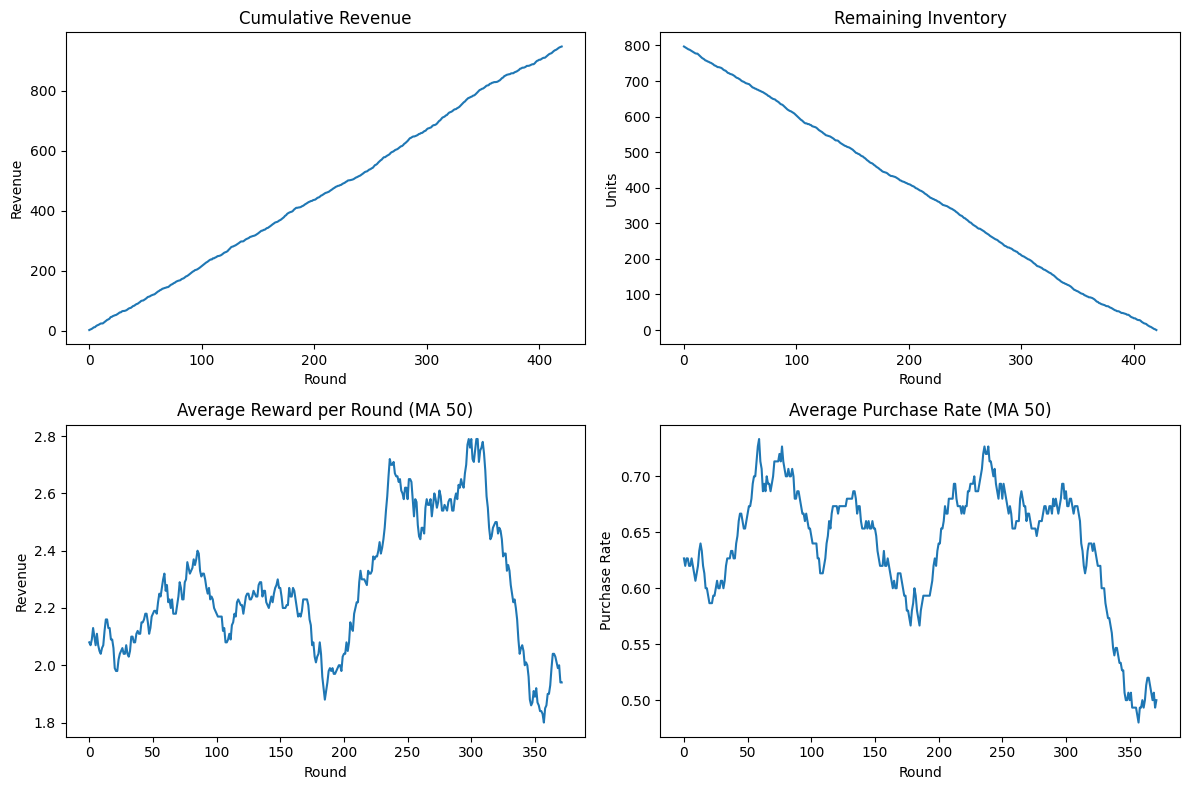

In [44]:

if __name__ == "__main__":
    # Run simulation
    agent, env = run_simulation()
    
    # Plot results
    plot_results(agent)